# MLE-5-Weekly Project




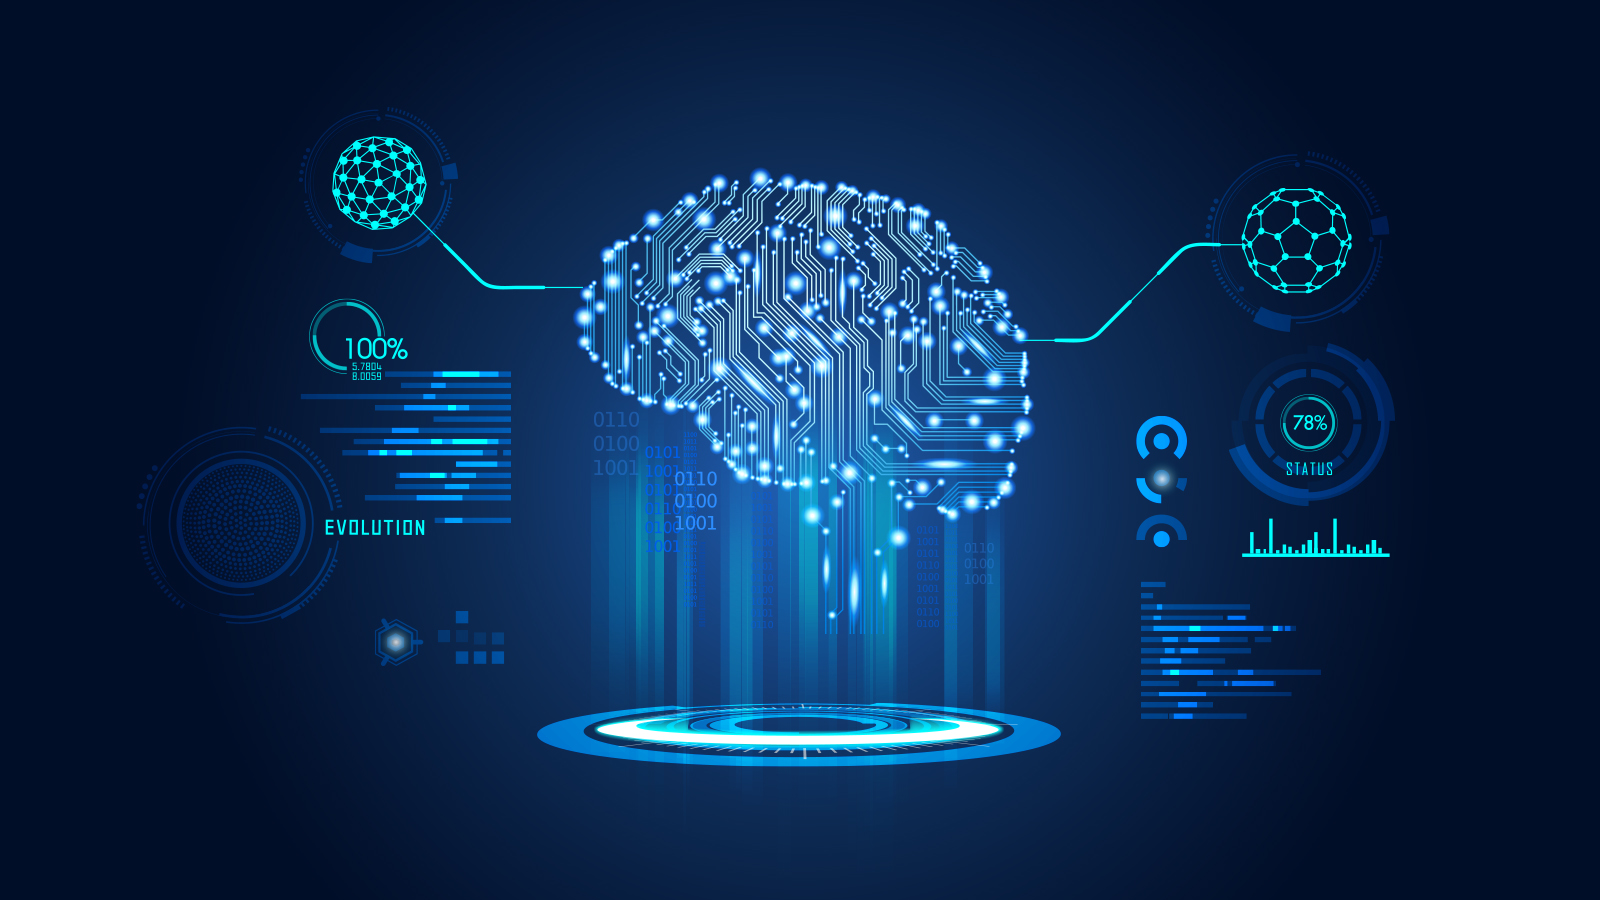

# Importing libraries

In [15]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

np.random.seed(1) # set a seed so that the results are consistent

In [16]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# Preparing dataset

In [17]:
# Load the data from h5 file
def load_dataset():
    train_dataset = h5py.File('./catsvsdogs-train.h5', "r")
    train_set_x_orig = np.array(train_dataset["images"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["labels"][:]) # your train set labels
    
    test_dataset = h5py.File('./catsvsdogs-test.h5', "r")
    test_set_x_orig = np.array(test_dataset["images"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["labels"][:]) # your test set labels
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig

In [18]:
train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig = load_dataset()

### Distinguish Dog and Cat
- Our dataset is a set of images, includes 5000 images of dogs and cats.
- The target is training a deep learning model to distinguish each image is dog or cat.

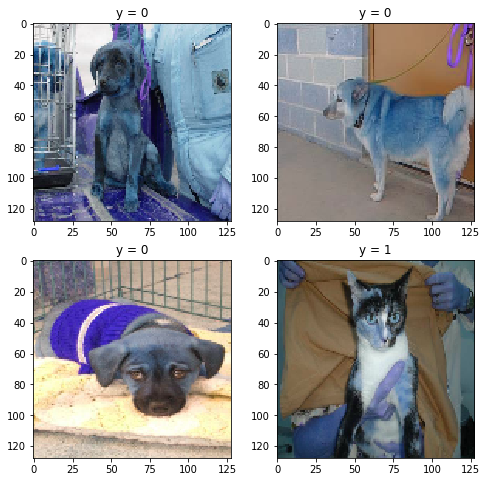

In [19]:
# Some some random images and their labels
plt.subplots(figsize = (8,8))
plt.subplot(221)
index_1 = np.random.randint(0,len(train_set_x_orig)) 
plt.imshow(train_set_x_orig[index_1])
plt.title("y = " + str(train_set_y_orig[index_1]))

plt.subplot(222)
index_2 = np.random.randint(0,len(train_set_x_orig))
plt.imshow(train_set_x_orig[index_2])
plt.title("y = " + str(train_set_y_orig[index_2]))

plt.subplot(223)
index_3 = np.random.randint(0,len(train_set_x_orig))
plt.imshow(train_set_x_orig[index_3])
plt.title("y = " + str(train_set_y_orig[index_3]))

plt.subplot(224)
index_4 = np.random.randint(0,len(train_set_x_orig))
plt.imshow(train_set_x_orig[index_4])
plt.title("y = " + str(train_set_y_orig[index_4]))

plt.show()

# Analyzing dataset

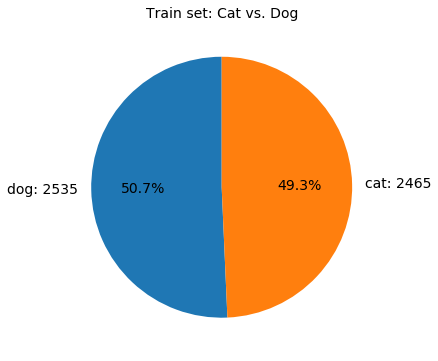

In [20]:
# Visualization the train set labels
unique, counts = np.unique(train_set_y_orig, return_counts = True)
dict1 = dict(zip(unique, counts))
plt.figure(figsize=(6,6))
plt.pie(x = counts, labels = ['dog: %s' % counts[0],'cat: %s' % counts[1]], autopct = '%1.1f%%', startangle=90, textprops={'fontsize': 14})
plt.title('Train set: Cat vs. Dog', fontdict={'fontsize': 14})
plt.show()

In [21]:
# Convert X to 2D array
X_train = train_set_x_orig.flatten().reshape((len(train_set_x_orig),-1)) / 255
X_test = test_set_x_orig.flatten().reshape((len(test_set_x_orig),-1)) / 255

# Convert y to 1D array
y_train = train_set_y_orig.reshape(1, -1)
y_test = test_set_y_orig.reshape(1, -1)

In [22]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5000, 49152), (1, 5000), (500, 49152), (1, 500))

## Building model

In this notebook, you will implement all the functions required to build a deep neural network.

![](https://i.imgur.com/ivhZhmx.png)

**Notation**:
- Superscript $[l]$ denotes a quantity associated with the $l^{th}$ layer. 
    - Example: $a^{[L]}$ is the $L^{th}$ layer activation. $W^{[L]}$ and $b^{[L]}$ are the $L^{th}$ layer parameters.
- Superscript $(i)$ denotes a quantity associated with the $i^{th}$ example. 
    - Example: $x^{(i)}$ is the $i^{th}$ training example.
- Lowerscript $i$ denotes the $i^{th}$ entry of a vector.
    - Example: $a^{[l]}_i$ denotes the $i^{th}$ entry of the $l^{th}$ layer's activations).
    
The initialization for a deeper L-layer neural network is more complicated because there are many more weight matrices and bias vectors. When completing the `initialize_params`, you should make sure that your dimensions match between each layer. Given $n^{[l]}$ is the number of units in layer $l$. Thus for example if the size of our input $X$ is $(12288, 209)$ (with $m=209$ examples) then:

| |**Shape of W**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; |**Shape of b**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|**Activation**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|**Shape of Activation**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|
|:-|:-|:-|:-|:-|
|**Layer 1**|$(n^{[1]},12288)$|$(n^{[1]},1)$|$Z^{[1]} = W^{[1]}  X + b^{[1]} $|$(n^{[1]},209)$|
| **Layer 2**|$(n^{[2]}, n^{[1]})$|$(n^{[2]},1)$|$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$|$(n^{[2]}, 209)$|
|$\vdots$| $\vdots$ | $\vdots$|$\vdots$|$\vdots$|
|**Layer L-1** | $(n^{[L-1]}, n^{[L-2]})$ | $(n^{[L-1]}, 1)$ | $Z^{[L-1]} =  W^{[L-1]} A^{[L-2]} + b^{[L-1]}$ | $(n^{[L-1]}, 209)$|
|**Layer L** | $(n^{[L]}, n^{[L-1]})$ | $(n^{[L]}, 1)$|  $Z^{[L]} =  W^{[L]} A^{[L-1]} + b^{[L]}$|$(n^{[L]}, 209)$ |

Remember that when we compute $W X + b$ in python, it carries out broadcasting. For example, if: 

$$ W = \begin{bmatrix}
    j  & k  & l\\
    m  & n & o \\
    p  & q & r 
\end{bmatrix}\;\;\; X = \begin{bmatrix}
    a  & b  & c\\
    d  & e & f \\
    g  & h & i 
\end{bmatrix} \;\;\; b =\begin{bmatrix}
    s  \\
    t  \\
    u
\end{bmatrix}$$

Then $WX + b$ will be:

$$ WX + b = \begin{bmatrix}
    (ja + kd + lg) + s  & (jb + ke + lh) + s  & (jc + kf + li)+ s\\
    (ma + nd + og) + t & (mb + ne + oh) + t & (mc + nf + oi) + t\\
    (pa + qd + rg) + u & (pb + qe + rh) + u & (pc + qf + ri)+ u
\end{bmatrix}$$

**Mathematical expression of the algorithm**:

![](https://i.imgur.com/FPjpVDX.png)

**Foward propagation:**

The linear forward module (vectorized over all the examples) computes the following equations:

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}$$

where $A^{[0]} = X^T$. And the activation functions:

$$A = RELU(Z) = max(0, Z)$$
$$A^{[L]} = sigmoid(Z^{[L]})$$

**Cost function**

$$J = -\frac1m\sum \bigg( Y \odot log(A^{[L]}) + (1-Y) \odot log(1-A^{[L]}) \bigg)$$

> Note that $\odot$ denotes elementwise multiplication.

**Backward propagation**

The three outputs $(dZ^{[l]}, dW^{[l]}, db^{[l]})$ are computed using the input $dZ^{[l]}$.Here are the formulas you need:

$$dZ^{[l]} =   W^{[l+1]^T}dZ^{[l+1]} \odot g^{[l]'}(Z^{[l]})$$
$$ dW^{[l]} = \frac{\partial \mathcal{L} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T}$$
$$ db^{[l]} = \frac{\partial \mathcal{L} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}$$




# Preparing some needed functions before training model

In [23]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

In [24]:
def relu(Z):
    return np.maximum(0, Z)

In [25]:
def relu_backward(Z):
    temp = np.ones(Z.shape)
    temp[Z<0] = 0
    return temp

### Layer sizes
- Create layer dimension by the following structure:
    - Number of features in Dataset (X.shape[1]) - Hidden layers - Output (Y.shape[0])

In [26]:
def layer_sizes(X, Y, hidden_layers):
    layer_dims = []
    n_x = X.shape[1]
    n_y = Y.shape[0]
    layer_dims = np.array(hidden_layers, copy=True)
    layer_dims = np.insert(layer_dims, 0, n_x)
    layer_dims = np.append(layer_dims, n_y)
    
    
    return layer_dims

layer_sizes(X_train, y_train, [20, 5, 7])

array([49152,    20,     5,     7,     1])

### Initialize W and b

In [27]:
def initialize_params(layer_dims):
    np.random.seed(1)
    
    parameters = {}
    L = len(layer_dims)

    for i in range(1, L): 
        parameters["W"+str(i)] = np.random.randn(layer_dims[i], layer_dims[i-1]) / np.sqrt(layer_dims[i-1])
        parameters["b"+str(i)] = np.zeros((layer_dims[i], 1))
    
        assert parameters["W" + str(i)].shape == (layer_dims[i], layer_dims[i-1])
        assert parameters["b" + str(i)].shape == (layer_dims[i], 1)

    
    return parameters

### Foward function
- Receive Dataset **X and parameters** from initialzie_params function
- Calculate and return **A and Z** from **1 to L-1**
- In last A, we will use **sigmoid** instead of **relu**

In [28]:
def forward_propagation(X, parameters):
    caches = {}
    A_prev = X.T
    L = len(parameters)//2
    
    A_last = []
    
    for i in range(1, L):
        Zi = np.dot(parameters["W"+str(i)], A_prev) + parameters["b"+str(i)]
        Ai = relu(Zi)
      
        caches['Z'+str(i)] = Zi
        caches['A'+str(i)] = Ai
      
        A_prev = Ai

    Z_last = np.dot(parameters["W"+str(L)], A_prev) + parameters["b"+str(L)]
    
    A_last = sigmoid(Z_last)

    caches['Z'+str(L)] = Z_last
    caches['A'+str(L)] = A_last
    
    m = X.shape[0]    
    assert (A_last.shape==(1,m))
    
    return A_last, caches


In [29]:
def compute_cross_entropy_cost(A_last, Y):
    J = 0
    m = Y.shape[1]
    
    loss = np.multiply(Y, np.log(A_last)) + np.multiply(1-Y, np.log(1-A_last))
    J = (-1/m) * np.sum(loss)
    J = np.squeeze(J)
    
    return J

In [30]:
def backward_propagation(X, Y, parameters, caches):

    L = len(parameters)//2
    m = X.shape[0]
    grads = {}
    A_last = caches["A"+str(L)]
    A_prev_last = caches["A"+str(L-1)]
    

    dZ_last = A_last - Y
    dW_last = (1/m) * np.dot(dZ_last, A_prev_last.T)
    db_last = (1/m) * np.sum(dZ_last, axis=1, keepdims=True)
    
    grads['dZ'+str(L)] = dZ_last
    grads['dW'+str(L)] = dW_last
    grads['db'+str(L)] = db_last
    
    for i in range(L-1, 0, -1):
        Ai_prev = caches['A'+str(i-1)] if i>1 else X.T
        grads['dZ'+str(i)] = np.multiply(np.dot(parameters["W"+str(i+1)].T, grads["dZ"+str(i+1)]), relu_backward(caches["Z"+str(i)]))
        grads['dW'+str(i)] = (1/m) * np.dot(grads['dZ'+str(i)], Ai_prev.T)
        grads['db'+str(i)] = (1/m) * np.sum(grads['dZ'+str(i)], axis=1, keepdims=True)
     
    return grads

In [31]:
def update_parameters(parameters, grads, learning_rate):
        
    L = len(parameters) // 2

    for i in range(1, L+1):
        parameters["W" + str(i)] = parameters["W" + str(i)] - learning_rate * grads["dW" + str(i)]
        parameters["b" + str(i)] = parameters["b" + str(i)] - learning_rate * grads["db" + str(i)]
                
    return parameters

### Build our neural network in `dnn_model()`

In [32]:
def dnn_model(X, Y, hidden_layers, iterations, learning_rate):
    
    layer_dims = layer_sizes(X, Y, hidden_layers) 
    parameters = initialize_params(layer_dims)
     
    costs = []
    test_errors = []
    
    for i in range(iterations):
        # Forward propagation
        A_last, cache = forward_propagation(X, parameters)
        # Calculate cost
        J = compute_cross_entropy_cost(A_last, Y)
        # Backward propagation
        grads = backward_propagation(X, Y, parameters, cache)
        # Update parameters
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if i % 100 == 0:
            print('Iteration %i, Cost: %f' % (i, J))
            costs.append(J)
            A2_test, _ = forward_propagation(X_test, parameters)
            predictions = A2_test > 0.5
            test_errors.append(1 - accuracy_score(y_test[0], predictions[0]))
            
            
    # plot the cost
    fig, ax = plt.subplots(figsize=(6,8))
    plt.plot(costs)
    plt.plot(test_errors, c='r')
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters
            

In [33]:
def predict(X, parameters):
    predictions = []
    A_last, cache = forward_propagation(X, parameters)
    predictions = A_last > 0.5
    return predictions

# TEST

Iteration 0, Cost: 0.693017
Iteration 100, Cost: 0.680860
Iteration 200, Cost: 0.671538
Iteration 300, Cost: 0.664369
Iteration 400, Cost: 0.659274
Iteration 500, Cost: 0.654943
Iteration 600, Cost: 0.649757
Iteration 700, Cost: 0.645877
Iteration 800, Cost: 0.641280
Iteration 900, Cost: 0.636523
Iteration 1000, Cost: 0.632345
Iteration 1100, Cost: 0.626655
Iteration 1200, Cost: 0.622544
Iteration 1300, Cost: 0.617395
Iteration 1400, Cost: 0.612100
Iteration 1500, Cost: 0.607894
Iteration 1600, Cost: 0.605296
Iteration 1700, Cost: 0.599037
Iteration 1800, Cost: 0.593598
Iteration 1900, Cost: 0.588976


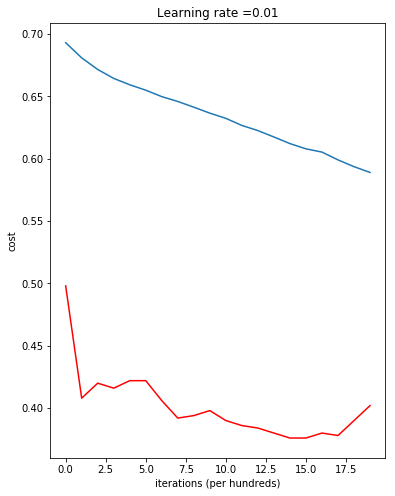

In [61]:
parameters = dnn_model(X_train, y_train, hidden_layers=[7,10,20,7,7,9], iterations=2000, learning_rate=0.01)

predictions = predict(X_test, parameters)
# hidden_layers=[20,10,7], iterations=2000, learning_rate=0.0015 : 62,6%
# hidden_layers=[7,10,10,8,7], iterations=2000, learning_rate=0.0015 : 63,4%
# hidden_layers=[7,10,10,8,7], iterations=2000, learning_rate=0.005 : 63000
# hidden_layers=[7,10,10,8,7], iterations=2000, learning_rate=0.001 : 63%
# hidden_layers=[20,10,10,20,20], iterations=2000, learning_rate=0.0015 : 63.15
# hidden_layers=[20,10,10,20,20], iterations=500, learning_rate=0.005 : 635
# hidden_layers=[20,10,20], iterations=500, learning_rate=0.005 : 61%
# hidden_layers=[20,10,20], iterations=500, learning_rate=0.01 : 61,6%
# hidden_layers=[20,10,20], iterations=3000, learning_rate=0.0001 : 58,8% --underfit
# hidden_layers=[20,10,20], iterations=3000, learning_rate=0.001 : 61,8%
# hidden_layers=[20,7,9], iterations=3000, learning_rate=0.03 : 60,8%
# hidden_layers=[20,7,7,9], iterations=2500, learning_rate=0.003 : 62%
# hidden_layers=[20,7,7,9], iterations=3000, learning_rate=0.003 : 62%
# hidden_layers=[20,7,7,9], iterations=2500, learning_rate=0.007 : 58 % 
# hidden_layers=[20,7,7,9], iterations=2500, learning_rate=0.002 : 62.6%
# hidden_layers=[20,7,7,9], iterations=2500, learning_rate=0.001 :64,4%
# hidden_layers=[20,7,7,9], iterations=2500, learning_rate=0.0005 : 64,2%
# hidden_layers=[10,20,7,7,9], iterations=2500, learning_rate=0.001 : 57,8%
# hidden_layers=[10,20,7,7,9], iterations=2500, learning_rate=0.01 :65,8%
# hidden_layers=[7,10,20,7,7,9], iterations=2500, learning_rate=0.005 : 60,6%
# hidden_layers=[7,10,20,7,7,9], iterations=2500, learning_rate=0.01 : 66,2% -------------best
# hidden_layers=[7,10,20,7,7,9], iterations=3000, learning_rate=0.01 : 62,2%
# hidden_layers=[7,10,20,7,7,9], iterations=2500, learning_rate=0.015 : 64,6%
# hidden_layers=[7,10,20,7,7,9,8], iterations=2500, learning_rate=0.01 : 65,6%
# hidden_layers=[7,10,20,7,7,9,8], iterations=3000, learning_rate=0.01 : 59,6%
# hidden_layers=[7,10,20,7,7,9,8], iterations=3000, learning_rate=0.005 : 64,8%

In [64]:
predictions = predict(X_train, parameters)
print("Accuracy Score - Training set: %f" % accuracy_score(y_train[0], predictions[0]))
print("Confusion Matrix:")
print(confusion_matrix(y_train[0], predictions[0]))

Accuracy Score - Training set: 0.691200
Confusion Matrix:
[[1340 1195]
 [ 349 2116]]


In [65]:
predictions = predict(X_test, parameters)

print("Accuracy Score: %f" % accuracy_score(y_test[0], predictions[0]))
print("Confusion Matrix:")
print(confusion_matrix(y_test[0], predictions[0]))

Accuracy Score: 0.638000
Confusion Matrix:
[[117 138]
 [ 43 202]]


## Save/ Load model

### Saving

In [2]:
import pickle

In [94]:
filename = 'finalized_model.sav'
pickle.dump(dnn_model, open(filename, 'wb'))

### Loading

In [3]:
filename = 'finalized_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)

AttributeError: Can't get attribute 'dnn_model' on <module '__main__'>

## Model from sklearn

Try a sklearn model to solve the problem, let's see if your model can overpass it.

In [39]:
lg = LogisticRegression()
lg.fit(X_train, y_train[0])

# Show metrics
print("Accuracy Score: %f" % accuracy_score(y_test[0], lg.predict(X_test)))
print("Confusion Matrix:")
print(confusion_matrix(y_test[0], lg.predict(X_test)))

Accuracy Score: 0.576000
Confusion Matrix:
[[130 125]
 [ 87 158]]
